In [64]:
!git clone https://github.com/Kyksi/HumourDetection.git

Cloning into 'HumourDetection'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [73]:
!pip install pickle5
!python -m spacy download en_core_web_md
# Please restart env after executing above command [Runtime -> Restart runtime]

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [66]:
import re
import spacy
import pickle5 as pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
from textblob.translate import NotTranslated
from random import SystemRandom
from urllib.error import HTTPError
from collections import Counter

In [67]:
maxlen = 280
nb_words = 10000
embedding_dim = 50

UNK = '<UNK>'

nlp = spacy.load('en_core_web_md')

In [74]:

def remove_stop_words(sentence):
    return ' '.join([word for word in sentence.split() if word not in ENGLISH_STOP_WORDS])


def translation_augmentation(sentence, aug_range=1):
    augmented_sentences = []
    sr = SystemRandom()
    language = ["es", "de", "fr", "ko", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps",
                "am", "ar", "hr", "cs", "el", "it", "lv", "pl", "ru", "sw", "sv", "vi", "cy", "tr", "ur", "mr"]
    for j in range(0, aug_range):
        text = TextBlob(sentence)
        try:
            text = text.translate(to=sr.choice(language))  # Converting to random language for meaningful variation
            text = text.translate(to="en")
        except NotTranslated:
            pass
        augmented_sentences.append(str(text))
    return augmented_sentences


def check_lemma(t, w):
    r = [d for d in t if (nlp(d.text)[0].lemma_ != nlp(w.text)[0].lemma_)]
    return r


def get_word_synonym(word):
    filtered_words = [w for w in word.vocab if (
        not w.lower_ in ENGLISH_STOP_WORDS) and w.is_lower == word.is_lower]
    similarity = sorted(filtered_words, key=lambda w: word.similarity(w), reverse=True)
    filtered_similarity = check_lemma(similarity[:30], word)
    return filtered_similarity[:3]


def similarity_augmentation(sentence, s_dict, aug_range=1):
    sr = SystemRandom()
    split_pattern = re.compile(r'\s+')
    augmented_sentences = []
    for j in range(0, aug_range):
        new_s = ""
        for i in filter(None, split_pattern.split(sentence)):
            new_s = new_s + " " + sr.choice(s_dict.get(i, [i]))
        augmented_sentences.append(new_s)
    return augmented_sentences


def load_pretrained_embeddings(filename='glove.6B.50d.txt', from_pickle=False):
    if from_pickle:
        with open(filename, 'rb') as f:
            _embedding_matrix = pickle.load(f)
    else:
        _embeddings_index = {}
        with open(filename) as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                _embeddings_index[word] = coefs
        _embedding_matrix = np.zeros((nb_words, embedding_dim))
        for word, i in tokenizer.word_index.items():
            if i < nb_words:
                embedding_vector = _embeddings_index.get(word)
                if embedding_vector is not None:
                    _embedding_matrix[i] = embedding_vector
    return _embedding_matrix


def _round(number, step=0.5):
    return ceil(number) if number % 1 > step else floor(number)


def view_graphs(history):
    metrics = list(history.history.keys())

    def plot(metric):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_' + metric])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot(metrics[0])
    plt.subplot(1, 2, 2)
    plot(metrics[1])
    plt.show()


def shuffle_data(texts, labels):
    indices = np.arange(texts.shape[0])
    np.random.shuffle(indices)
    data = texts[indices]
    labels = labels[indices]
    return data, labels


def predict(sentence, model):
    sentence = tokenizer.texts_to_sequences([sentence])
    pad_word = pad_sequences(sentence, maxlen=maxlen, padding='post')
    result = model.predict(pad_word)
    print(result)
    return result

In [75]:
# Load data for humor detection
data_detection = pd.read_csv('HumourDetection/Data/train.csv', usecols=['text', 'is_humor'])
# data_detection.text = [remove_stop_words(i) for i in data_detection.text]

# Load data for humor rating (not a humor rows are not included)
data_ratings = pd.read_csv('HumourDetection/Data/train.csv', usecols=['text', 'humor_rating']).dropna()
# data_ratings.text = [remove_stop_words(i) for i in data_ratings.text]

tokenizer = Tokenizer(num_words=nb_words, oov_token=UNK)
tokenizer.fit_on_texts(data_detection.text)

embedding_matrix = load_pretrained_embeddings(filename='HumourDetection/Precalculated/embedding_matrix.pickle', from_pickle=True)
# embedding_matrix = load_pretrained_embeddings(filename='HumourDetection/Precalculated/embedding_matrix_stop_words.pickle', from_pickle=True)
# embedding_matrix = load_pretrained_embeddings()  # if load from glove embeddings file

In [76]:
def get_classes_dist(data):
    c = Counter(data)
    _all = sum(c.values())
    classes_dict = {label: value / _all for label, value in c.items()}
    return classes_dict


def create_synonym_dict(filename=None):
    if filename:
        with open(filename, 'rb') as f:
            filtered_synonym = pickle.load(f)
    else:
        synonym_dict = {}
        for _word, i in tokenizer.word_index.items():
            if i < nb_words and _word != UNK:
                synonym_dict.update({_word: tuple([w.lower_ for w in get_word_synonym(nlp.vocab[_word])])})

        value_occurrences = Counter(synonym_dict.values())
        filtered_synonym = {key: value for key, value in synonym_dict.items() if value_occurrences[value] == 1}
    return filtered_synonym

Humor detaction class, implementing CNN for binary classification [humor/not humor]

In [77]:
class HumorDetection:
    def __init__(self):
        self.texts = None
        self.labels = None
        self.model = None
        self.history = None

        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None

        self.learning_rate = 55e-5
        self.batch_size = 256
        self.epochs = 20

    def _format_data(self):
        self.texts = pad_sequences(
            tokenizer.texts_to_sequences(data_detection.text),
            maxlen=maxlen)
        self.labels = np.array(data_detection.is_humor)
        self.texts, self.labels = shuffle_data(self.texts, self.labels)

    def _define_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(nb_words, embedding_dim, input_length=maxlen,
                                      mask_zero=True, weights=[embedding_matrix]),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv1D(filters=128, kernel_size=4,
                                   activation='relu', strides=1, use_bias=False),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    def _compile_model(self):
        self.model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           metrics=['accuracy'])
        self.model.summary()

    def evaluate(self):
        print("Evaluate on test data")
        results = self.model.evaluate(self.x_test, self.y_test)
        print("test loss, test acc:", results)

    def main(self, model_name=None):
        self._format_data()
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.texts, self.labels, test_size=0.1)
        if not model_name:
            self._define_model()
            self._compile_model()
            self.history = self.model.fit(self.x_train, self.y_train,
                                          batch_size=self.batch_size,
                                          epochs=self.epochs,
                                          validation_split=0.15)
        else:
            self.model = tf.keras.models.load_model(model_name)

In [78]:
class HumorRating:
    def __init__(self):
        self.texts = None
        self.labels = None
        self.model = None
        self.history = None

        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None

        self.learning_rate = 55e-5
        self.batch_size = 256
        self.epochs = 15

    def _format_data(self, oversample=None):
        global tokenizer
        tokenized = False

        self.texts = [j for j in data_ratings.text]
        self.pre_labels = [round(x) for x in data_ratings.humor_rating]

        if oversample == 'smote':
            sm = SMOTE(random_state=42)
            self.texts = pad_sequences(tokenizer.texts_to_sequences(self.texts), maxlen=maxlen)
            self.labels = tf.keras.utils.to_categorical(self.pre_labels)
            self.texts, self.labels = sm.fit_resample(self.texts, self.labels)
            tokenized = True
        elif oversample == 'translate_augmentation':
            classes_dist = get_classes_dist(self.pre_labels)
            tmp_l = self.pre_labels.copy()
            try:
                for i, label in enumerate(tmp_l):
                    if classes_dist[label] < 0.25:
                        aug_range = floor(0.25 / classes_dist[label])
                        new_data = translation_augmentation(self.texts[i], aug_range=aug_range)
                        for d in new_data:
                            self.texts.append(d)
                            self.pre_labels.append(label)
            except HTTPError:
                print("Error: Too Many Requests. Data augmentation process wasn't properly finished.")
        elif oversample == 'similarity_augmentation':
            self.s_dict = create_synonym_dict(filename='Precalculated/words_synonyms.pickle')
            classes_dist = get_classes_dist(self.pre_labels)
            tmp_l = self.pre_labels.copy()
            for i, label in enumerate(tmp_l):
                if classes_dist[label] < 0.25:
                    aug_range = floor(0.25 / classes_dist[label])
                    new_data = similarity_augmentation(self.texts[i], self.s_dict, aug_range=aug_range)
                    for d in new_data:
                        self.texts.append(d)
                        self.pre_labels.append(label)
            tokenizer = Tokenizer(num_words=nb_words, oov_token=UNK)
            tokenizer.fit_on_texts(self.texts)

        if not tokenized:
            self.texts = pad_sequences(tokenizer.texts_to_sequences(self.texts), maxlen=maxlen)
            self.labels = tf.keras.utils.to_categorical(self.pre_labels)

        self.texts, self.labels = shuffle_data(self.texts, self.labels)

    def _define_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(nb_words, embedding_dim, input_length=maxlen,
                                      mask_zero=True, weights=[embedding_matrix]),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(64)
            ),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(5, activation='softmax')
        ])

    def _compile_model(self):
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                           metrics=[tf.keras.metrics.Recall()])
        self.model.summary()

    def evaluate(self):
        print("Evaluate on test data")
        results = self.model.evaluate(self.x_test, self.y_test)
        print("test loss, test acc:", results)

    def main(self, model_name=None):
        self._format_data(oversample='similarity_augmentation')
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.texts, self.labels, test_size=0.1)
        if not model_name:
            self._define_model()
            self._compile_model()
            self.history = self.model.fit(self.x_train, self.y_train,
                                          batch_size=self.batch_size,
                                          epochs=self.epochs,
                                          validation_split=0.15)
        else:
            self.model = tf.keras.models.load_model(model_name)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 280, 50)           500000    
_________________________________________________________________
dropout_58 (Dropout)         (None, 280, 50)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 277, 128)          25600     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_59 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)              

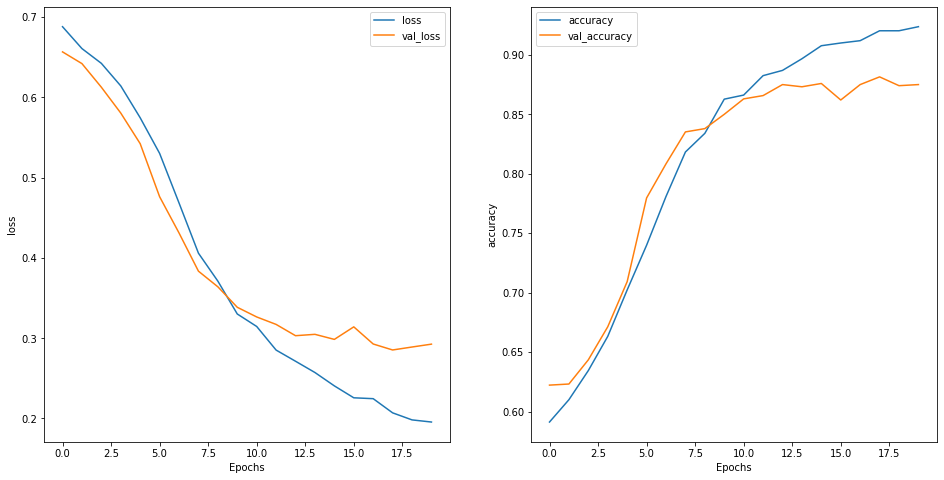

[[0.03309605]]
[[0.00297912]]
[[0.8962113]]
[[0.7746289]]
[[0.03340288]]
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 280, 50)           500000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_69 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
______________________________________________

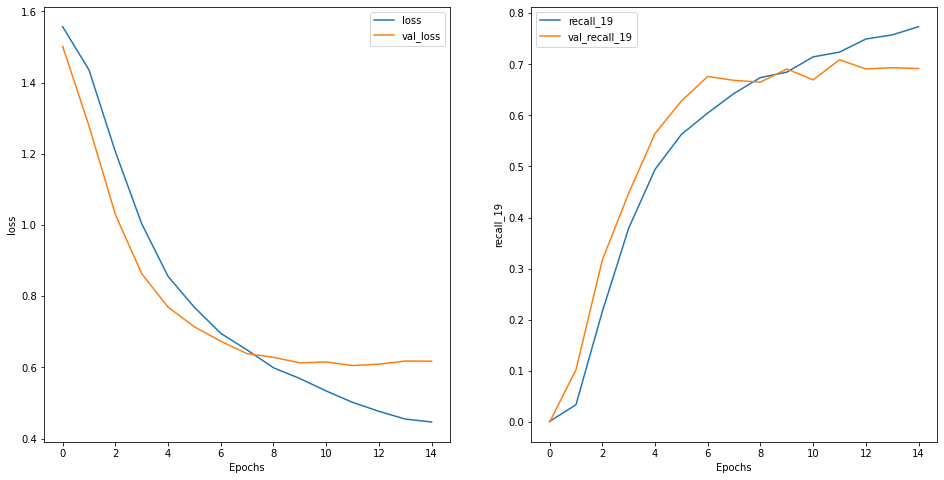

Evaluate on test data
27/27 [==============================] - 3s 118ms/step - loss: 0.6004 - recall_19: 0.7088
test loss, test acc: [0.6003829836845398, 0.7088167071342468]
[[1.5430062e-04 1.5237678e-02 7.1756327e-01 2.6679322e-01 2.5152077e-04]]
[[8.9953668e-05 1.3437082e-02 7.6968908e-01 2.1663417e-01 1.4971010e-04]]
[[0.00312995 0.09460484 0.60037786 0.29979643 0.00209095]]
[[0.00089988 0.01914258 0.30464745 0.6684538  0.00685628]]
[[0.00712872 0.13708705 0.5947843  0.25864914 0.00235079]]


In [80]:
sentences = [
    'Where do generals keep their armies? In their sleevies!',
    'FACTS provides solutions that elevate the K-12 experience for school administrators, teachers, and families.',
    'This website is using a security service to protect itself from online attacks.',
    'What did the grape say when it was stepped on? Nothing, it just let out a little wine.',
    'With around 200 countries and more than 7.8 billion people (plus plants, animals, and other organisms), '
    'the world is full of interesting, fun, and fascinating facts'
]

if __name__ == '__main__':
    hd = HumorDetection()
    hd.main()
    hd.evaluate()
    view_graphs(hd.history)
    for s in sentences:
        predict(s, model=hd.model)

    hr = HumorRating()
    hr.main()
    view_graphs(hr.history)
    hr.evaluate()
    for s in sentences:
        predict(s, model=hr.model)